# 1. Import libraries

In [17]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, confusion_matrix

In [18]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 10,5

# 2. Import datasets

In [21]:
df = pd.read_csv("../inputs/1_Bins.csv")
df.shape

(9578, 13)

# 3. Model

In [22]:
y = df['Def']
x = df.drop(['delinq_2yrs_bin','int_rate_bin','Def'], axis=1)
tf.random.set_seed(108)

In [23]:
model = Sequential() 
model.add(Dense(10, activation='tanh', input_dim=10, kernel_regularizer=l2(0.001))) 
model.add(Dropout(0.0005))
model.add(Dense(10, activation='tanh', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.0005))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='AUC') 
model.fit(x,y,epochs=500,batch_size=100,verbose=0,callbacks=EarlyStopping(monitor='loss',patience=3))

# 4. Model - final

In [24]:
pred_values = model.predict(x)
pred_values = pd.DataFrame(pred_values)[0]
print('AUROC:',np.round(roc_auc_score(y, pred_values), 3))

300/300 [==============================] - 0s 1ms/step
AUROC: 0.67


In [25]:
auroc = roc_auc_score(y, pred_values)
gini = 2 * auroc - 1
print('Gini:',np.round(gini, 3))

Gini: 0.34


# 5. Confusion Matrix

In [26]:
train_dict = {'actuals':y, 'predicted':pred_values}
test_calc = pd.DataFrame(train_dict)

max f:  0.15


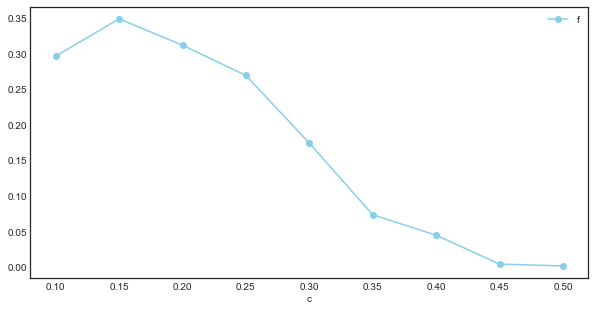

In [27]:
c = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
f = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
i = 0
for j in c:
    def flag(x):
        if x > j: return 1
        else: return 0
    test_calc['flag'] = test_calc['predicted'].apply(flag)
    df_table = confusion_matrix(test_calc['actuals'],test_calc['flag'])
    p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
    r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
    f[i] = (2 * p * r) / (p + r)
    i = i+1

df_decision = pd.concat([pd.DataFrame(c),pd.DataFrame(f)],axis=1)
df_decision.columns = ['c','f']
f_max = df_decision[df_decision['f']==df_decision['f'].max()].head(1)
max_f = float(f_max['c'])

df_decision.plot(x='c',y='f',marker="o", color='skyblue')
print ("max f: ",max_f)

# 6. Accuracy and F1

In [28]:
def cut_off (x):
    if x > 0.15: return 1
    else: return 0
test_calc['flag'] = test_calc['predicted'].apply(cut_off)
print(confusion_matrix(test_calc['actuals'],test_calc['flag']))

[[5514 2531]
 [ 675  858]]


In [29]:
c = confusion_matrix(test_calc['actuals'],test_calc['flag'])
print('Accuracy:',np.round((c[0][0] + c[1][1]) / c.sum(),3))

Accuracy: 0.665


In [30]:
p = c[1][1] / (c[1][1] + c[0][1])
r = c[1][1] / (c[1][1] + c[1][0])
print('F1 Score:',np.round((2 * p * r) / (p + r),3))

F1 Score: 0.349


# 7. KS

In [31]:
test_calc = test_calc.sort_values('predicted', ascending=False)
test_calc['def'] = test_calc['predicted']
test_calc['non_def'] = 1-test_calc['predicted']
test_calc['bins'] = pd.qcut(test_calc['non_def'], 5, labels=[0,1,2,3,4])

test_calc = test_calc.groupby('bins').agg({'def':'sum', 'non_def':'sum'}).reset_index()
test_calc = test_calc.sort_values('bins')
test_calc['def'] = test_calc['def'] / test_calc['def'].sum()
test_calc['non_def'] = test_calc['non_def'] / test_calc['non_def'].sum()

test_calc['def'] = test_calc['def'].cumsum()
test_calc['non_def'] = test_calc['non_def'].cumsum()
test_calc['KS'] = test_calc['def'] - test_calc['non_def']
print(test_calc)
print('\n KS:',np.round(test_calc['KS'].max(),3))

  bins       def   non_def        KS
0    0  0.339424  0.174418  0.165007
1    1  0.545183  0.375379  0.169805
2    2  0.721689  0.585483  0.136206
3    3  0.886999  0.806083  0.080916
4    4  1.000000  1.000000  0.000000

 KS: 0.17


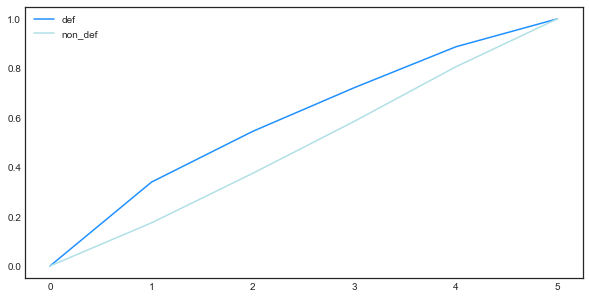

In [32]:
train_dict = {'bins':[-1],'def':[0],'non_def':[0],'KS':[0]}
train_dict = pd.DataFrame.from_dict(train_dict)
test_calc = pd.concat([train_dict,test_calc]).reset_index()

plt.plot(test_calc['def'], color='dodgerblue', label='def')
plt.plot(test_calc['non_def'], color='powderblue', label='non_def')
plt.legend();